# 07/22/2024

Changed to be with constant regularization factor from TG

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
sys.path.append(os.path.abspath("/Users/miraliu/Desktop/PostDocCode/PartialNephrectomy_Python"))
sys.path.append(os.path.abspath("/Users/miraliu/Desktop/PostDocCode/RenalAllograft_Python"))

#sys.path.append('../')
from ML_UsefulFunctions import *
from KidneyROIAnalyses import *
from RenalAllograftFunctions import *
from DataLeakageCorrections import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format

from scipy.stats import f_oneway

from collections import Counter
from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")

/Users/miraliu/anaconda3/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
fileloc = '/Users/miraliu/Desktop/Data/RA/RenalAllograft_IVIM/RA_DiffusionSpectra_IVIM_CORRECTED.xlsx'
#Multiexp_Data = pd.read_excel(fileloc,sheet_name = 'Voxelwise_sortedfourpeaks_take2') ## take2 or not here
Multiexp_Data = pd.read_excel(fileloc,sheet_name = 'Sortedfourpeaks_smplNNLS')
Multiexp_Data["Record ID"] = Multiexp_Data["Record ID"].str.replace("_P", "_")


fileloc = '/Users/miraliu/Desktop/Data/RA/GCO202690RAMulticent-BanffScores_DATA_LABELS_2024-04-19_1316.xlsx'
RA_Database_Patients = pd.read_excel(fileloc, sheet_name = 'GCO202690RAMulticent-BanffScore',header = 0) 
RA_Database_Patients["Record ID"] = RA_Database_Patients["Record ID"].str.replace("_P", "_")

Cases_to_Run = pd.merge(Multiexp_Data, RA_Database_Patients[['Record ID', 'Interstitial Fibrosis Tubular Atrophy (ci+ct)']], how = 'inner', left_on=["Record ID"], right_on = ['Record ID'])
Cases_to_Run = Cases_to_Run.drop_duplicates(keep='first',ignore_index = True)

Cases_to_Run_cortical = Cases_to_Run.loc[Multiexp_Data['ROI Type'].str.endswith('C')]
Cases_to_Run_medullar = Cases_to_Run.loc[Multiexp_Data['ROI Type'].str.endswith('M')]

# now get the data from the database that you want. 
# IFTA, ct, ci, etc
# this is just to convert the words to numbers

RA_Database_Patients['tubulitis val'] = RA_Database_Patients['Tubulitis (t)'].str[1:2]
RA_Database_Patients['interstitial inflammation val'] = RA_Database_Patients['Interstitial Inflammation (i)'].str[1:2]
RA_Database_Patients['Inflammation in iIFTA val'] = RA_Database_Patients['Inflammation in Areas of Interstitial Fibrosis and Tubular Atrophy (iIFTA)'].str[6:7]
RA_Database_Patients['Glomerulitis val'] = RA_Database_Patients['Glomerulitis (g)'].str[1:2]
RA_Database_Patients['Arteriolar Hyalinosis val'] = RA_Database_Patients['Arteriolar Hyalinosis (ah)'].str[2:3]
RA_Database_Patients['Interstitial Fibrosis val'] = RA_Database_Patients['Interstitial Fibrosis (ci)'].str[2:3]
RA_Database_Patients['Tubular Atrophy val'] = RA_Database_Patients['Tubular Atrophy (ct)'].str[2:3]
RA_Database_Patients['Interstitial Fibrosis Tubular Atrophy (ci+ct) val'] = RA_Database_Patients['Interstitial Fibrosis Tubular Atrophy (ci+ct)']

#addign more classifications
RA_Database_Patients['cg val'] = RA_Database_Patients['Glomerular basement membrane double contours (cg)'].str[2:3]
RA_Database_Patients['Interstitial Inflammation val'] = RA_Database_Patients['Interstitial Inflammation (i)'].str[1:2]
RA_Database_Patients['iIFTA val'] = RA_Database_Patients['Inflammation in Areas of Interstitial Fibrosis and Tubular Atrophy (iIFTA)'].str[6:7]
RA_Database_Patients['pct val'] = RA_Database_Patients['Peritubular Capillary Inflammation (ptc)'].str[3:4]

Original_features = list(Multiexp_Data.iloc[:, 2:42].columns)
cortical_features = list()
for j in range(len(Original_features)):
    cortical_features.append('cortical ' + Original_features[j])
All_features = cortical_features 

voxelwise_IVIM_columns = ['Record ID'] + cortical_features  + ['tubulitis', 'interstitial inflammation', 'inflammation in IFTA', 'glomerulitis', 'arteriolar hyalinosis', 'interstitial fibrosis (ci)', 'tubular atrophy (ct)', 'IFTA']

def GetRA_Spectrum(RecordNumber,MR_Data,Record_Data,columns):
        
    cortical = MR_Data.loc[(MR_Data['Record ID'] == RecordNumber) & (MR_Data['ROI Type'].str.endswith('C'))]
    medullar = MR_Data.loc[(MR_Data['Record ID'] == RecordNumber) & (MR_Data['ROI Type'].str.endswith('M'))]
    #p
    CorticalMean = cortical[columns].mean(axis=0,numeric_only=True)
    #MedullarMean = medullar[columns].mean(axis=0,numeric_only=True)
    
    tubulitis = Record_Data['tubulitis val'].loc[Record_Data['Record ID'] == RecordNumber]
    interstitial_infl = Record_Data['interstitial inflammation val'].loc[Record_Data['Record ID'] == RecordNumber]
    iIFTA_infl = Record_Data['Inflammation in iIFTA val'].loc[Record_Data['Record ID'] == RecordNumber]
    Glomerulitis = Record_Data['Glomerulitis val'].loc[Record_Data['Record ID'] == RecordNumber]
    ArteriolarHya = Record_Data['Arteriolar Hyalinosis val'].loc[Record_Data['Record ID'] == RecordNumber]
    
    Ci = Record_Data['Interstitial Fibrosis val'].loc[Record_Data['Record ID'] == RecordNumber]
    Ct = Record_Data['Tubular Atrophy val'].loc[Record_Data['Record ID'] == RecordNumber]
    IFTA = Record_Data['Interstitial Fibrosis Tubular Atrophy (ci+ct)'].loc[Record_Data['Record ID'] == RecordNumber]
    #adding more traits
    Cg = Record_Data['cg val'].loc[Record_Data['Record ID'] == RecordNumber]


    Ival = Record_Data['Interstitial Inflammation val'].loc[Record_Data['Record ID'] == RecordNumber]

    iIFTA = Record_Data['iIFTA val'].loc[Record_Data['Record ID'] == RecordNumber]

    pct = Record_Data['pct val'].loc[Record_Data['Record ID'] == RecordNumber]

    
    return np.array(CorticalMean).T, np.array(tubulitis), np.array(interstitial_infl), np.array(iIFTA_infl), np.array(Glomerulitis), np.array(ArteriolarHya), np.array(Ci), np.array(Ct), np.array(IFTA), np.array(Cg), np.array(Ival), np.array(iIFTA), np.array(pct)

def RetrieveData_FourpeakSpectrum(Cases_to_Run,Biexp_Data,RA_DatabasePatients):
    Original_features = list(Multiexp_Data.iloc[:, 2:42].columns)
    cortical_features = list()
    for j in range(len(Original_features)):
        cortical_features.append('cortical ' + Original_features[j])
    All_features = cortical_features 

    voxelwise_IVIM_columns = ['Record ID'] + cortical_features  + ['tubulitis', 'interstitial inflammation', 'inflammation in IFTA', 'glomerulitis', 'arteriolar hyalinosis', 'interstitial fibrosis (ci)', 'tubular atrophy (ct)', 'IFTA', 'Cg', 'Ival', 'iIFTA','pct'] 

    
    #add banff cats
    Banff = [col for col in RA_Database_Patients.columns if 'Banff Categories' in col]
    voxelwise_IVIM_columns = voxelwise_IVIM_columns + Banff + ['tubular injury']
    
    cort,tubulitis, interstitial_infl, iIFTA_infl, glomerulitis, AH, Ci, Ct, IFTA, Cg, Ival, iIFTA, pct=GetRA_Spectrum(Cases_to_Run.at[0,'Record ID'],Biexp_Data,RA_DatabasePatients, Original_features)
    output_banff_categories = GetBanffCategories(Cases_to_Run.at[0,'Record ID'],Biexp_Data,RA_DatabasePatients, Original_features)
    
    datamerge = np.ndarray.tolist(np.concatenate([cort,tubulitis, interstitial_infl, iIFTA_infl, glomerulitis, AH, Ci, Ct, IFTA, Cg, Ival, iIFTA, pct]))
    datamerge = datamerge + output_banff_categories
    datamerge.insert(0,Cases_to_Run.at[0,'Record ID'])

    df = pd.DataFrame([datamerge],columns = voxelwise_IVIM_columns)

    for j in range(len(Cases_to_Run)-1):
        name = Cases_to_Run.at[j+1,'Record ID'] #get jth patient
        #print(name)
        cort,tubulitis, interstitial_infl, iIFTA_infl, glomerulitis, AH, Ci, Ct, IFTA, Cg, Ival, iIFTA, pct=GetRA_Spectrum(name,Biexp_Data,RA_DatabasePatients,Original_features)
        output_banff_categories = GetBanffCategories(name,Biexp_Data,RA_DatabasePatients, Original_features)
        datamerge = np.ndarray.tolist(np.concatenate([cort,tubulitis, interstitial_infl, iIFTA_infl, glomerulitis, AH, Ci, Ct, IFTA, Cg, Ival, iIFTA, pct]))
        datamerge = datamerge + output_banff_categories

        datamerge.insert(0,name)
        df2 = pd.DataFrame([datamerge],columns = voxelwise_IVIM_columns)
        df = pd.concat([df,df2],ignore_index=True)
    # now also remove banff
    df = df.drop(Banff, axis=1)
    return df

def GetBanffCategories(RecordNumber, MR_Data, Record_Data, columns):

    output_banff_categories = []
    Banff = [col for col in RA_Database_Patients.columns if 'Banff Categories' in col] #get columns that start with "Banff Categories"
    for cat in Banff:
        #print(cat)
        #print(Record_Data[cat].loc[Record_Data['Record ID'] == RecordNumber])
        holder = BinarizeChecked(Record_Data[cat].loc[Record_Data['Record ID'] == RecordNumber]) #binarize checked and unchecked into 1 and 0
        output_banff_categories.append(holder)
    # also include Acutue tubular injury
    holder = BinarizeChecked(Record_Data['Other Diagnosis (choice=Acute tubular injury)'].loc[Record_Data['Record ID'] == RecordNumber]) #binarize checked and unchecked into 1 and 0
    output_banff_categories.append(holder)
    return output_banff_categories
    
RA_Database = RetrieveData_FourpeakSpectrum(Cases_to_Run,Multiexp_Data,RA_Database_Patients)
RA_Database = RA_Database.dropna(subset = 'IFTA')


#why are there duplicates? 
RA_Database = RA_Database.drop_duplicates(keep='first',ignore_index = True)


# remove site 2
#RA_Database = RA_Database[RA_Database['Record ID'].str.contains('_01_')]


## now add the fD
RA_Database['fD blood mean']=RA_Database['cortical mean f blood']*RA_Database['cortical mean D blood']
RA_Database['fD tubule mean']=RA_Database['cortical mean f tubule']*RA_Database['cortical mean D tubule']
RA_Database['fD tissue mean']=RA_Database['cortical mean f tissue']*RA_Database['cortical mean D tissue']
RA_Database['fD fibro mean']=RA_Database['cortical mean f fibro']*RA_Database['cortical mean D fibro']

RA_Database['fD blood median']=RA_Database['cortical median f blood']*RA_Database['cortical median D blood']
RA_Database['fD tubule median']=RA_Database['cortical median f tubule']*RA_Database['cortical median D tubule']
RA_Database['fD tissue median']=RA_Database['cortical median f tissue']*RA_Database['cortical median D tissue']
RA_Database['fD fibro median']=RA_Database['cortical median f fibro']*RA_Database['cortical median D fibro']

## now re-place them
ReIndex = ['fD blood mean', 'fD tubule mean', 'fD tissue mean', 'fD fibro mean', 'fD blood median','fD tubule median','fD tissue median','fD fibro median']
for j in range(len(ReIndex)):
    col = RA_Database.pop(ReIndex[j])
    RA_Database.insert(41, col.name, col)

ParameterComparisonHead = ['parameter name', 'group 1 $\mu \pm \sigma$', 'group 2 $\mu \pm \sigma$', 'p-value']


## now add the slow combined

RA_Database['D slow combined mean']=(RA_Database['cortical mean f tissue']*RA_Database['cortical mean D tissue'] + RA_Database['cortical mean f fibro']*RA_Database['cortical mean D fibro'])/(RA_Database['cortical mean f tissue'] + RA_Database['cortical mean f fibro'])
RA_Database['f slow combined mean']=RA_Database['cortical mean f tissue'] + RA_Database['cortical mean f fibro']
RA_Database['fD slow combined mean']=RA_Database['D slow combined mean'] + RA_Database['f slow combined mean']


RA_Database['D slow combined median']=(RA_Database['cortical median f tissue']*RA_Database['cortical median D tissue'] + RA_Database['cortical median f fibro']*RA_Database['cortical median D fibro'])/(RA_Database['cortical median f tissue'] + RA_Database['cortical median f fibro'])
RA_Database['f slow combined median']=RA_Database['cortical median f tissue'] + RA_Database['cortical median f fibro']
RA_Database['fD slow combined median']=RA_Database['D slow combined median'] + RA_Database['f slow combined median']


## now re-place them
ReIndex = ['D slow combined mean','f slow combined mean','fD slow combined mean','D slow combined median','f slow combined median','fD slow combined median']
for j in range(len(ReIndex)):
    col = RA_Database.pop(ReIndex[j])
    RA_Database.insert(49, col.name, col)

ParameterComparisonHead = ['parameter name', 'group 1 $\mu \pm \sigma$', 'group 2 $\mu \pm \sigma$', 'p-value']
#RA_Database.iloc[:,49:55]


fileloc = '/Users/miraliu/Desktop/Data/RA/GCO202690RAMulticent-Octavia_DATA_LABELS_2024-04-18_1424.xlsx'
RA_wEGFR = pd.read_excel(fileloc, sheet_name = 'GCO202690RAMulticent-Octavia_DA',header = 0) 
RA_wEGFR["Record ID"] = RA_wEGFR["Record ID"].str.replace("_P", "_")

RA_Database2 = pd.merge(RA_Database, RA_wEGFR[['Record ID', 'GFR CKD EPI']], how = 'inner', left_on=["Record ID"], right_on = ['Record ID'])


In [3]:


SelectedFeatures = ['fD tissue mean', 'fD tissue median', 'fD tubule mean', 'fD tubule median', 'fD blood mean', 'fD blood median', 'fD slow combined mean', 'fD slow combined median']
df = RA_Database2.dropna(subset = 'IFTA')
df = df.dropna(subset = 'GFR CKD EPI')

df['allograft status'] = df['GFR CKD EPI']
df['allograft status'].loc[(df['GFR CKD EPI'] > 45) &(df['IFTA'] == 0)] = 0 #'Healthy Function'
df['allograft status'].loc[(df['GFR CKD EPI'] <= 45) &(df['IFTA'] == 0)] = 1 #'No fibrosis impaired function'
df['allograft status'].loc[(df['GFR CKD EPI'] > 45) &(df['IFTA'] > 0)] = 2 #'Fibrosis with normal function'
df['allograft status'].loc[(df['GFR CKD EPI'] <= 45) &(df['IFTA'] > 0)] = 3 #'Fibrosis with impaired function'


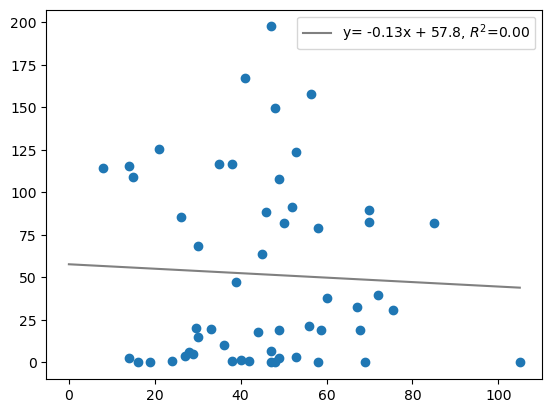

In [4]:
AllGFR = df['GFR CKD EPI']
AllfDTubule = 112.5*df['fD tubule mean']

pl.scatter(AllGFR, AllfDTubule)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(AllGFR, AllfDTubule)
r_value2 = r_value**2
x = np.linspace(0, max(AllGFR))
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.show()

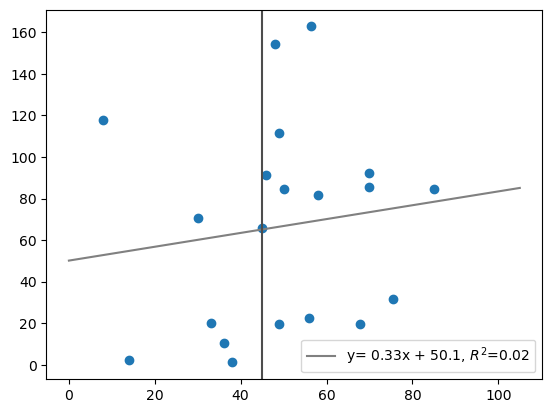

SignificanceResult(statistic=0.23401060048165384, pvalue=0.32070025332709234)


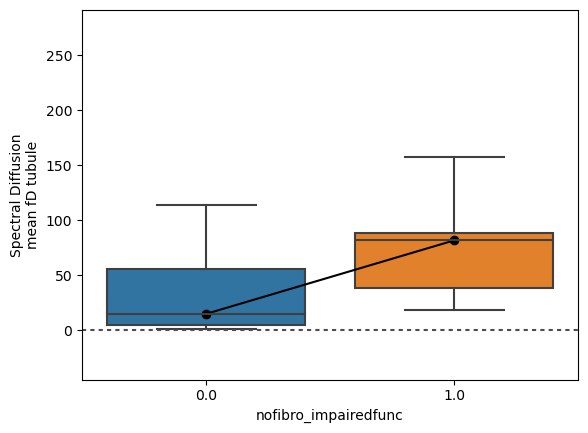

RanksumsResult(statistic=-1.8970080273373418, pvalue=0.0578268786434286)
correlation of tubular flow against eGFR
SignificanceResult(statistic=0.032695315153940176, pvalue=0.8144405023083318)


In [5]:
NoFibroGFR = df['GFR CKD EPI'].loc[df['IFTA']==0]
NoFibrofDTubule = 116*df['fD tubule mean'].loc[df['IFTA']==0]

pl.scatter(NoFibroGFR, NoFibrofDTubule)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(NoFibroGFR, NoFibrofDTubule)
r_value2 = r_value**2
x = np.linspace(0, max(AllGFR))
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.axvline(45, color=".3")#, dashes=(2, 2))

pl.show()

print(stats.spearmanr(NoFibroGFR, NoFibrofDTubule))


df_nofib=df.loc[df['IFTA']==0]
df_nofib['nofibro_impairedfunc'] = df_nofib['GFR CKD EPI']
df_nofib['nofibro_impairedfunc'].loc[df_nofib['GFR CKD EPI']<45] = 0
df_nofib['nofibro_impairedfunc'].loc[df_nofib['GFR CKD EPI']>=45] = 1




sns.boxplot(x=df_nofib['nofibro_impairedfunc'].loc[df_nofib['IFTA']==0], y=112*df_nofib['fD tubule mean'].loc[df_nofib['IFTA']==0])#,showmeans=True )
#pl.axvline(.5, color=".3")#, dashes=(2, 2))
pl.scatter([0,1], np.array([np.median(df_nofib['fD tubule mean'].loc[(df_nofib['nofibro_impairedfunc']==0)]), np.median(df_nofib['fD tubule mean'].loc[(df_nofib['nofibro_impairedfunc']==1)])])*112, color = 'black')
pl.plot([0,1], np.array([np.median(df_nofib['fD tubule mean'].loc[(df_nofib['nofibro_impairedfunc']==0)]), np.median(df_nofib['fD tubule mean'].loc[(df_nofib['nofibro_impairedfunc']==1)])])*112, color = 'black', linestyle = '-')

pl.ylim(-.4*112, 2.6*112)
pl.ylabel('Spectral Diffusion\nmean fD tubule')
pl.axhline(0, color=".3", dashes=(2, 2))

pl.show()
print(scipy.stats.ranksums(df_nofib['fD tubule mean'].loc[(df_nofib['nofibro_impairedfunc']==0)], df_nofib['fD tubule mean'].loc[(df_nofib['nofibro_impairedfunc']==1)]))



print('correlation of tubular flow against eGFR')
GFR = df['GFR CKD EPI'].loc[df['IFTA']>=0]
fDTubule = 116*df['fD tubule mean'].loc[df['IFTA']>=0]
print(stats.spearmanr(GFR, fDTubule))


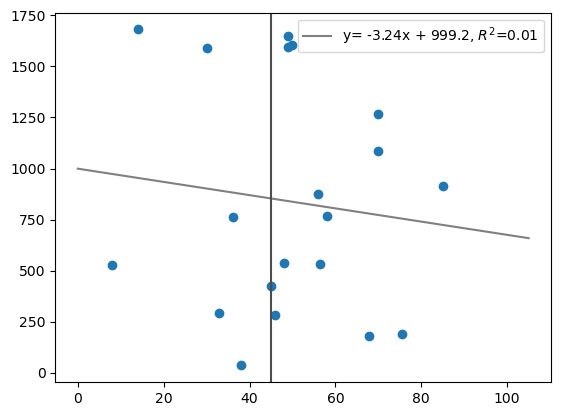

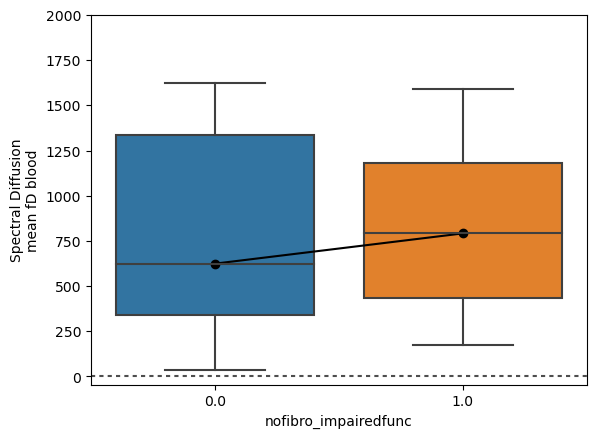

RanksumsResult(statistic=-0.329914439536929, pvalue=0.7414646126329769)


In [6]:
NoFibroGFR = df['GFR CKD EPI'].loc[df['IFTA']==0]
NoFibrofDblood = 116*df['fD blood mean'].loc[df['IFTA']==0]

pl.scatter(NoFibroGFR, NoFibrofDblood)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(NoFibroGFR, NoFibrofDblood)
r_value2 = r_value**2
x = np.linspace(0, max(AllGFR))
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.axvline(45, color=".3")#, dashes=(2, 2))

pl.show()

stats.spearmanr(NoFibroGFR, NoFibrofDblood)

df_nofib=df.loc[df['IFTA']==0]
df_nofib['nofibro_impairedfunc'] = df_nofib['GFR CKD EPI']
df_nofib['nofibro_impairedfunc'].loc[df_nofib['GFR CKD EPI']<45] = 0
df_nofib['nofibro_impairedfunc'].loc[df_nofib['GFR CKD EPI']>=45] = 1





sns.boxplot(x=df_nofib['nofibro_impairedfunc'].loc[df_nofib['IFTA']==0], y=112*df_nofib['fD blood mean'].loc[df_nofib['IFTA']==0])#,showmeans=True )
#pl.axvline(.5, color=".3")#, dashes=(2, 2))
pl.scatter([0,1], np.array([np.median(df_nofib['fD blood mean'].loc[(df_nofib['nofibro_impairedfunc']==0)]), np.median(df_nofib['fD blood mean'].loc[(df_nofib['nofibro_impairedfunc']==1)])])*112, color = 'black')
pl.plot([0,1], np.array([np.median(df_nofib['fD blood mean'].loc[(df_nofib['nofibro_impairedfunc']==0)]), np.median(df_nofib['fD blood mean'].loc[(df_nofib['nofibro_impairedfunc']==1)])])*112, color = 'black', linestyle = '-')

pl.ylim(-.4*112, 2000)
pl.ylabel('Spectral Diffusion\nmean fD blood')
pl.axhline(0, color=".3", dashes=(2, 2))

pl.show()

print(scipy.stats.ranksums(df_nofib['fD blood mean'].loc[(df_nofib['nofibro_impairedfunc']==0)], df_nofib['fD blood mean'].loc[(df_nofib['nofibro_impairedfunc']==1)]))




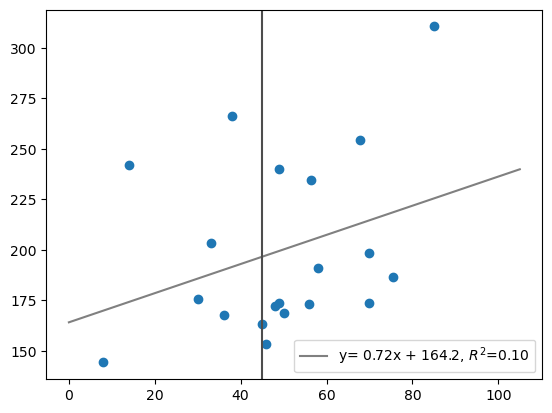

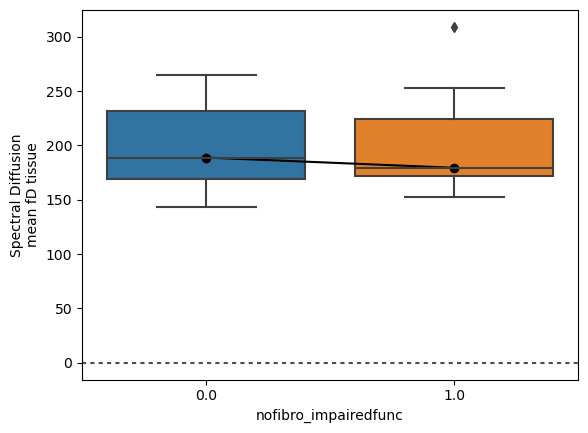

RanksumsResult(statistic=0.1649572197684645, pvalue=0.8689776543645945)


In [7]:
NoFibroGFR = df['GFR CKD EPI'].loc[df['IFTA']==0]
NoFibrofDtissue = 112.5*df['fD tissue mean'].loc[df['IFTA']==0]

pl.scatter(NoFibroGFR, NoFibrofDtissue)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(NoFibroGFR, NoFibrofDtissue)
r_value2 = r_value**2
x = np.linspace(0, max(AllGFR))
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.axvline(45, color=".3")#, dashes=(2, 2))

pl.show()

stats.spearmanr(NoFibroGFR, NoFibrofDtissue)

df_nofib=df.loc[df['IFTA']==0]
df_nofib['nofibro_impairedfunc'] = df_nofib['GFR CKD EPI']
df_nofib['nofibro_impairedfunc'].loc[df_nofib['GFR CKD EPI']<45] = 0
df_nofib['nofibro_impairedfunc'].loc[df_nofib['GFR CKD EPI']>=45] = 1





sns.boxplot(x=df_nofib['nofibro_impairedfunc'].loc[df_nofib['IFTA']==0], y=112*df_nofib['fD tissue mean'].loc[df_nofib['IFTA']==0])#,showmeans=True )
#pl.axvline(.5, color=".3")#, dashes=(2, 2))
pl.scatter([0,1], np.array([np.median(df_nofib['fD tissue mean'].loc[(df_nofib['nofibro_impairedfunc']==0)]), np.median(df_nofib['fD tissue mean'].loc[(df_nofib['nofibro_impairedfunc']==1)])])*112, color = 'black')
pl.plot([0,1], np.array([np.median(df_nofib['fD tissue mean'].loc[(df_nofib['nofibro_impairedfunc']==0)]), np.median(df_nofib['fD tissue mean'].loc[(df_nofib['nofibro_impairedfunc']==1)])])*112, color = 'black', linestyle = '-')

#pl.ylim(-.4, 2.6)
pl.ylabel('Spectral Diffusion\nmean fD tissue')
pl.axhline(0, color=".3", dashes=(2, 2))

pl.show()

print(scipy.stats.ranksums(df_nofib['fD tissue mean'].loc[(df_nofib['nofibro_impairedfunc']==0)], df_nofib['fD tissue mean'].loc[(df_nofib['nofibro_impairedfunc']==1)]))




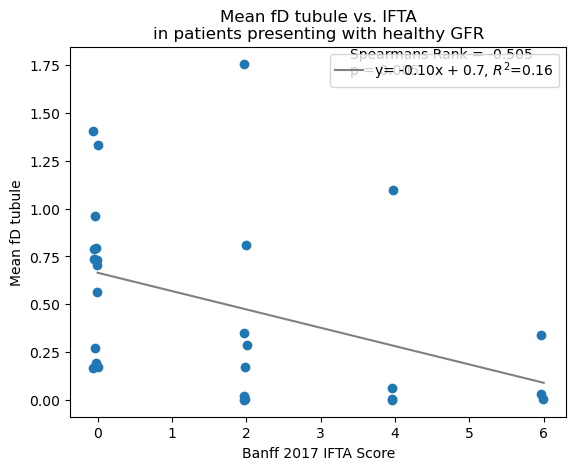

SignificanceResult(statistic=-0.47729052510590986, pvalue=0.008840481000654966)
IFTA scores: Counter({0.0: 14, 2.0: 8, 4.0: 4, 6.0: 3})


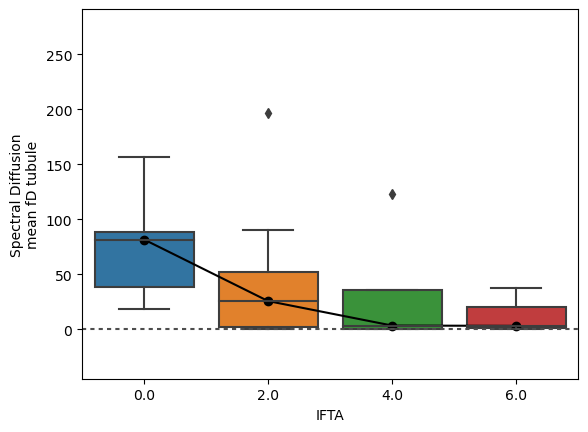

F_onewayResult(statistic=1.6905115861850297, pvalue=0.1945526875082096)


In [8]:
FibroHealthyGFR = df['IFTA'].loc[df['GFR CKD EPI']>=45]
NoFibrofDTubule = df['fD tubule mean'].loc[df['GFR CKD EPI']>=45]

randomnoise = np.random.normal(-.02,.02,len(FibroHealthyGFR)) # just for plotting clarity
pl.scatter(FibroHealthyGFR+randomnoise, NoFibrofDTubule)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(FibroHealthyGFR, NoFibrofDTubule)
r_value2 = r_value**2
x = np.linspace(0, max(FibroHealthyGFR))
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.title('Mean fD tubule vs. IFTA\nin patients presenting with healthy GFR')
pl.xlabel('Banff 2017 IFTA Score')
pl.ylabel('Mean fD tubule')
s = 'Spearmans Rank = -0.505\np = 0.005'
pl.text(3.4, 1.7, s)
pl.show()

print(stats.spearmanr(FibroHealthyGFR, NoFibrofDTubule))

print('IFTA scores:', Counter(FibroHealthyGFR))


df['healthifta'] = df['IFTA'].loc[df['GFR CKD EPI']>=45]
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==0)]=0
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==2)]=2
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==4)]=4
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==6)]=6
df2=df[['fD tubule mean','healthifta']].loc[df['GFR CKD EPI']>=45]

ParameterComparisonHead = ['parameter name', 'group 1 $\mu \pm \sigma$', 'group 2 $\mu \pm \sigma$', 'p-value']

#df_list = [Run_Iterative_Utest(df2, 'healthifta', int(i), int(j),ParameterComparisonHead,0,2) for i, j in combinations(df['healthifta'].unique().tolist(), 2)]
#final_df = pd.concat(df_list, ignore_index = True)
#display(final_df.loc[final_df['p-value'] <2].round(decimals = 5))






sns.boxplot(x=df['IFTA'].loc[df['GFR CKD EPI']>=45], y=112*df['fD tubule mean'].loc[df['GFR CKD EPI']>=45])#,showmeans=True )
#pl.axvline(.5, color=".3")#, dashes=(2, 2))
pl.scatter([0,1,2,3], np.array([np.median(df['fD tubule mean'].loc[(df['healthifta']==0)]), np.median(df['fD tubule mean'].loc[(df['healthifta']==2)]), np.median(df['fD tubule mean'].loc[(df['healthifta']==4)]), np.median(df['fD tubule mean'].loc[(df['healthifta']==6)])])*112, color = 'black')
pl.plot([0,1,2,3], np.array([np.median(df['fD tubule mean'].loc[(df['healthifta']==0)]), np.median(df['fD tubule mean'].loc[(df['healthifta']==2)]), np.median(df['fD tubule mean'].loc[(df['healthifta']==4)]), np.median(df['fD tubule mean'].loc[(df['healthifta']==6)])])*112, color = 'black', linestyle = '-')

pl.ylim(-.4*112, 2.6*112)
pl.ylabel('Spectral Diffusion\nmean fD tubule')
pl.axhline(0, color=".3", dashes=(2, 2))

pl.show()

print(scipy.stats.f_oneway(df['fD tubule mean'].loc[(df['healthifta']==0)], df['fD tubule mean'].loc[(df['healthifta']==2)], df['fD tubule mean'].loc[(df['healthifta']==4)], df['fD tubule mean'].loc[(df['healthifta']==6)]))


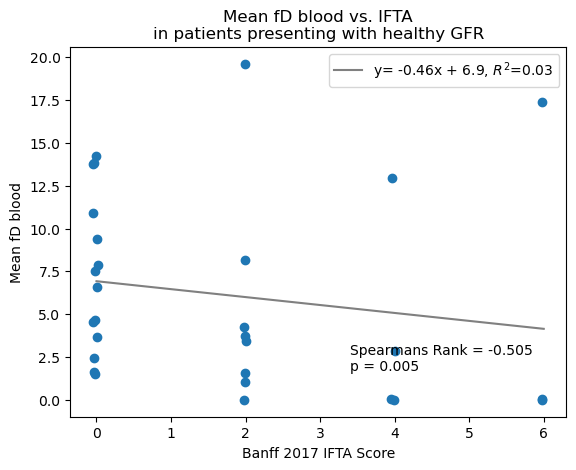

SignificanceResult(statistic=-0.3522472184431625, pvalue=0.060924718451188714)
IFTA scores: Counter({0.0: 14, 2.0: 8, 4.0: 4, 6.0: 3})


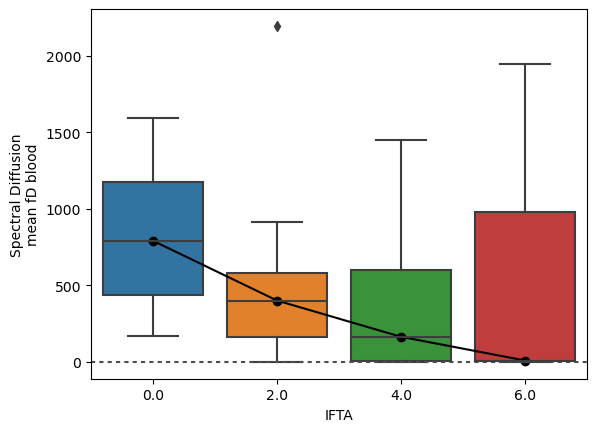

F_onewayResult(statistic=0.4421470001123206, pvalue=0.7249190626742604)


In [9]:
FibroHealthyGFR = df['IFTA'].loc[df['GFR CKD EPI']>=45]
NoFibrofDblood = df['fD blood mean'].loc[df['GFR CKD EPI']>=45]

randomnoise = np.random.normal(-.02,.02,len(FibroHealthyGFR)) # just for plotting clarity
pl.scatter(FibroHealthyGFR+randomnoise, NoFibrofDblood)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(FibroHealthyGFR, NoFibrofDblood)
r_value2 = r_value**2
x = np.linspace(0, max(FibroHealthyGFR))
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.title('Mean fD blood vs. IFTA\nin patients presenting with healthy GFR')
pl.xlabel('Banff 2017 IFTA Score')
pl.ylabel('Mean fD blood')
s = 'Spearmans Rank = -0.505\np = 0.005'
pl.text(3.4, 1.7, s)
pl.show()

print(stats.spearmanr(FibroHealthyGFR, NoFibrofDblood))

print('IFTA scores:', Counter(FibroHealthyGFR))


df['healthifta'] = df['IFTA'].loc[df['GFR CKD EPI']>=45]
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==0)]=0
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==2)]=2
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==4)]=4
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==6)]=6
df2=df[['fD blood mean','healthifta']].loc[df['GFR CKD EPI']>=45]

ParameterComparisonHead = ['parameter name', 'group 1 $\mu \pm \sigma$', 'group 2 $\mu \pm \sigma$', 'p-value']

#df_list = [Run_Iterative_Utest(df2, 'healthifta', int(i), int(j),ParameterComparisonHead,0,2) for i, j in combinations(df['healthifta'].unique().tolist(), 2)]
#final_df = pd.concat(df_list, ignore_index = True)
#display(final_df.loc[final_df['p-value'] <2].round(decimals = 5))






sns.boxplot(x=df['IFTA'].loc[df['GFR CKD EPI']>=45], y=112*df['fD blood mean'].loc[df['GFR CKD EPI']>=45])#,showmeans=True )
#pl.axvline(.5, color=".3")#, dashes=(2, 2))
pl.scatter([0,1,2,3], np.array([np.median(df['fD blood mean'].loc[(df['healthifta']==0)]), np.median(df['fD blood mean'].loc[(df['healthifta']==2)]), np.median(df['fD blood mean'].loc[(df['healthifta']==4)]), np.median(df['fD blood mean'].loc[(df['healthifta']==6)])])*112, color = 'black')
pl.plot([0,1,2,3], np.array([np.median(df['fD blood mean'].loc[(df['healthifta']==0)]), np.median(df['fD blood mean'].loc[(df['healthifta']==2)]), np.median(df['fD blood mean'].loc[(df['healthifta']==4)]), np.median(df['fD blood mean'].loc[(df['healthifta']==6)])])*112, color = 'black', linestyle = '-')

#pl.ylim(-.4, 2.6)
pl.ylabel('Spectral Diffusion\nmean fD blood')
pl.axhline(0, color=".3", dashes=(2, 2))

pl.show()

print(scipy.stats.f_oneway(df['fD blood mean'].loc[(df['healthifta']==0)], df['fD blood mean'].loc[(df['healthifta']==2)], df['fD blood mean'].loc[(df['healthifta']==4)], df['fD blood mean'].loc[(df['healthifta']==6)]))


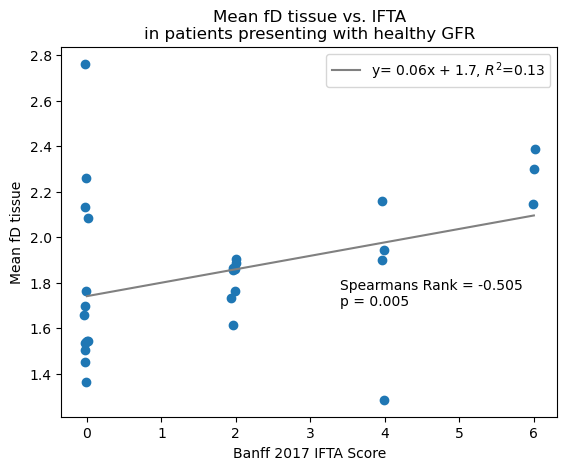

SignificanceResult(statistic=0.42932295983985225, pvalue=0.020118789420763877)
IFTA scores: Counter({0.0: 14, 2.0: 8, 4.0: 4, 6.0: 3})


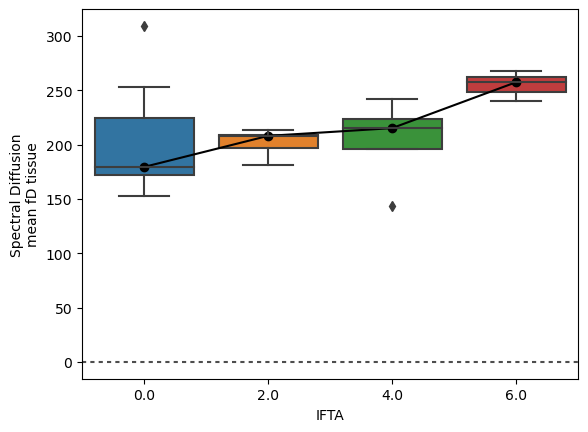

F_onewayResult(statistic=2.113797283690375, pvalue=0.12385361992080827)


In [10]:
FibroHealthyGFR = df['IFTA'].loc[df['GFR CKD EPI']>=45]
NoFibrofDtissue = df['fD tissue mean'].loc[df['GFR CKD EPI']>=45]

randomnoise = np.random.normal(-.02,.02,len(FibroHealthyGFR)) # just for plotting clarity
pl.scatter(FibroHealthyGFR+randomnoise, NoFibrofDtissue)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(FibroHealthyGFR, NoFibrofDtissue)
r_value2 = r_value**2
x = np.linspace(0, max(FibroHealthyGFR))
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.title('Mean fD tissue vs. IFTA\nin patients presenting with healthy GFR')
pl.xlabel('Banff 2017 IFTA Score')
pl.ylabel('Mean fD tissue')
s = 'Spearmans Rank = -0.505\np = 0.005'
pl.text(3.4, 1.7, s)
pl.show()

print(stats.spearmanr(FibroHealthyGFR, NoFibrofDtissue))

print('IFTA scores:', Counter(FibroHealthyGFR))


df['healthifta'] = df['IFTA'].loc[df['GFR CKD EPI']>=45]
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==0)]=0
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==2)]=2
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==4)]=4
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==6)]=6
df2=df[['fD tissue mean','healthifta']].loc[df['GFR CKD EPI']>=45]

ParameterComparisonHead = ['parameter name', 'group 1 $\mu \pm \sigma$', 'group 2 $\mu \pm \sigma$', 'p-value']

#df_list = [Run_Iterative_Utest(df2, 'healthifta', int(i), int(j),ParameterComparisonHead,0,2) for i, j in combinations(df['healthifta'].unique().tolist(), 2)]
#final_df = pd.concat(df_list, ignore_index = True)
#display(final_df.loc[final_df['p-value'] <2].round(decimals = 5))






sns.boxplot(x=df['IFTA'].loc[df['GFR CKD EPI']>=45], y=112*df['fD tissue mean'].loc[df['GFR CKD EPI']>=45])#,showmeans=True )
#pl.axvline(.5, color=".3")#, dashes=(2, 2))
pl.scatter([0,1,2,3], np.array([np.median(df['fD tissue mean'].loc[(df['healthifta']==0)]), np.median(df['fD tissue mean'].loc[(df['healthifta']==2)]), np.median(df['fD tissue mean'].loc[(df['healthifta']==4)]), np.median(df['fD tissue mean'].loc[(df['healthifta']==6)])])*112, color = 'black')
pl.plot([0,1,2,3], np.array([np.median(df['fD tissue mean'].loc[(df['healthifta']==0)]), np.median(df['fD tissue mean'].loc[(df['healthifta']==2)]), np.median(df['fD tissue mean'].loc[(df['healthifta']==4)]), np.median(df['fD tissue mean'].loc[(df['healthifta']==6)])])*112, color = 'black', linestyle = '-')

#pl.ylim(-.4, 2.6)
pl.ylabel('Spectral Diffusion\nmean fD tissue')
pl.axhline(0, color=".3", dashes=(2, 2))

pl.show()

print(scipy.stats.f_oneway(df['fD tissue mean'].loc[(df['healthifta']==0)], df['fD tissue mean'].loc[(df['healthifta']==2)], df['fD tissue mean'].loc[(df['healthifta']==4)], df['fD tissue mean'].loc[(df['healthifta']==6)]))


# add combined slow

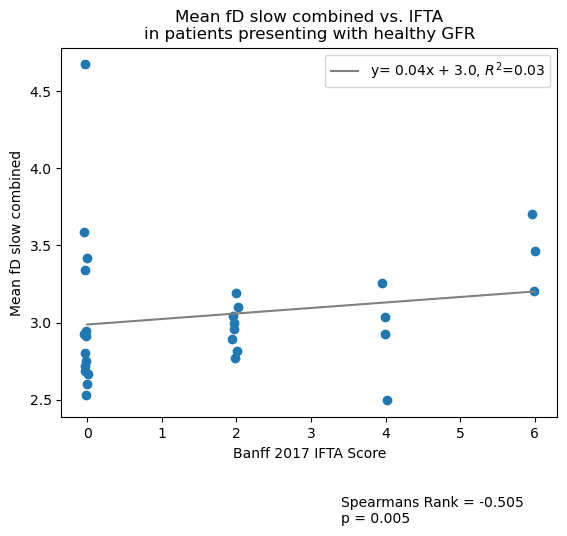

SignificanceResult(statistic=0.3124517096612258, pvalue=0.09890141232386553)
IFTA scores: Counter({0.0: 14, 2.0: 8, 4.0: 4, 6.0: 3})


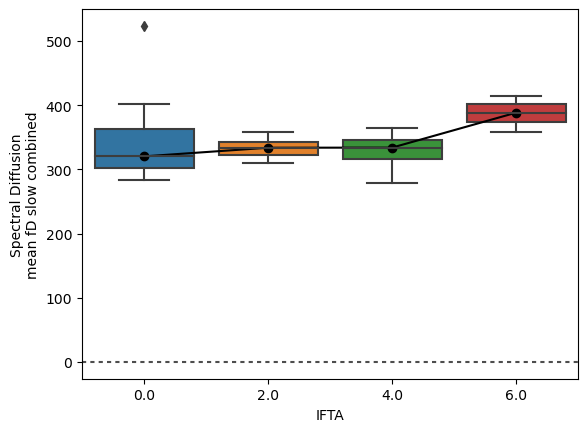

F_onewayResult(statistic=1.05420669589689, pvalue=0.3861094675362731)


In [13]:
FibroHealthyGFR = df['IFTA'].loc[df['GFR CKD EPI']>=45]
NoFibrofDslowcombined = df['fD slow combined mean'].loc[df['GFR CKD EPI']>=45]

randomnoise = np.random.normal(-.02,.02,len(FibroHealthyGFR)) # just for plotting clarity
pl.scatter(FibroHealthyGFR+randomnoise, NoFibrofDslowcombined)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(FibroHealthyGFR, NoFibrofDslowcombined)
r_value2 = r_value**2
x = np.linspace(0, max(FibroHealthyGFR))
pl.plot(x,func(x,slope,intercept),label = f'y= {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}',color = 'grey') 
pl.legend()
pl.title('Mean fD slow combined vs. IFTA\nin patients presenting with healthy GFR')
pl.xlabel('Banff 2017 IFTA Score')
pl.ylabel('Mean fD slow combined')
s = 'Spearmans Rank = -0.505\np = 0.005'
pl.text(3.4, 1.7, s)
pl.show()

print(stats.spearmanr(FibroHealthyGFR, NoFibrofDslowcombined))

print('IFTA scores:', Counter(FibroHealthyGFR))


df['healthifta'] = df['IFTA'].loc[df['GFR CKD EPI']>=45]
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==0)]=0
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==2)]=2
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==4)]=4
df['healthifta'].loc[(df['GFR CKD EPI']>=45) & (df['IFTA']==6)]=6
df2=df[['fD slow combined mean','healthifta']].loc[df['GFR CKD EPI']>=45]

ParameterComparisonHead = ['parameter name', 'group 1 $\mu \pm \sigma$', 'group 2 $\mu \pm \sigma$', 'p-value']

#df_list = [Run_Iterative_Utest(df2, 'healthifta', int(i), int(j),ParameterComparisonHead,0,2) for i, j in combinations(df['healthifta'].unique().tolist(), 2)]
#final_df = pd.concat(df_list, ignore_index = True)
#display(final_df.loc[final_df['p-value'] <2].round(decimals = 5))






sns.boxplot(x=df['IFTA'].loc[df['GFR CKD EPI']>=45], y=112*df['fD slow combined mean'].loc[df['GFR CKD EPI']>=45])#,showmeans=True )
#pl.axvline(.5, color=".3")#, dashes=(2, 2))
pl.scatter([0,1,2,3], np.array([np.median(df['fD slow combined mean'].loc[(df['healthifta']==0)]), np.median(df['fD slow combined mean'].loc[(df['healthifta']==2)]), np.median(df['fD slow combined mean'].loc[(df['healthifta']==4)]), np.median(df['fD slow combined mean'].loc[(df['healthifta']==6)])])*112, color = 'black')
pl.plot([0,1,2,3], np.array([np.median(df['fD slow combined mean'].loc[(df['healthifta']==0)]), np.median(df['fD slow combined mean'].loc[(df['healthifta']==2)]), np.median(df['fD slow combined mean'].loc[(df['healthifta']==4)]), np.median(df['fD slow combined mean'].loc[(df['healthifta']==6)])])*112, color = 'black', linestyle = '-')

#pl.ylim(-.4, 2.6)
pl.ylabel('Spectral Diffusion\nmean fD slow combined')
pl.axhline(0, color=".3", dashes=(2, 2))

pl.show()

print(scipy.stats.f_oneway(df['fD slow combined mean'].loc[(df['healthifta']==0)], df['fD slow combined mean'].loc[(df['healthifta']==2)], df['fD slow combined mean'].loc[(df['healthifta']==4)], df['fD slow combined mean'].loc[(df['healthifta']==6)]))
